<a href="https://colab.research.google.com/github/YifanXu1999/AI-Learning/blob/master/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
from torchvision.transforms import  transforms
import numpy as np
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt


In [4]:
trainSet = DataLoader(CIFAR10(root='./data', train=True, transform=transforms.ToTensor(), download=True), shuffle=True, batch_size=128)
testSet = DataLoader(CIFAR10(root='./data', train=True, transform=transforms.ToTensor(), download=True), shuffle=True, batch_size=16)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
class VAE(nn.Module):
    def __init__(self, latent_dim=20, hidden_dim=500):
        super(VAE, self).__init__()
        self.encoder_l1 = nn.Linear(32 * 32 * 3, hidden_dim)
        self.encoder_mean = nn.Linear(hidden_dim, latent_dim)
        self.encoder_logvar = nn.Linear(hidden_dim, latent_dim)
        self.decoder_l1 = nn.Linear(latent_dim, hidden_dim)
        self.decoder_output = nn.Linear(hidden_dim, 32 * 32 * 3)

    def encode(self, x_in):
        x = F.relu(self.encoder_l1(x_in.view(-1, 32 * 32 * 3)))
        mean = self.encoder_mean(x)
        logvar = self.encoder_logvar(x)
        return mean, logvar
    
    def decode(self, z):
        z = F.relu(self.decoder_l1(z))
        x_out = torch.sigmoid(self.decoder_output(z))
        return x_out
    
    def sample(self, mu, log_var):
        # z = mu + standard deviavation * eps
        eps = torch.normal(torch.zeros(size=mu.size()), torch.ones(size=log_var.size()))
        sd = torch.exp(log_var * 0.5)
        z = mu + sd * eps
        return z

    def forward(self, x_in):
        z_mean, z_logvar = self.encode(x_in)
        z = self.sample(z_mean, z_logvar)
        x_out = self.decode(z)
        return x_out, z_mean, z_logvar

In [0]:
def criterion(x_out, x_in, z_mu, z_logvar):
  bce_loss = F.binary_cross_entropy(x_out, x_in, size_average=False)
  kl_div = -0.5 * (1 + z_logvar - z_mu  ** 2 - torch.exp(z_logvar)).sum()
  loss = (bce_loss + kl_div) / x_out.size(0)
  return loss

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


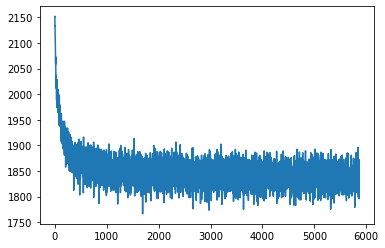

In [53]:
def train(dataset, model, optimizer, epochs=15):
  losses = []
  for epoch in range(epochs):
    for images,_ in dataset:
      optimizer.zero_grad()
      x_in = images
      x_out, z_mu, z_logvar = model(x_in)
      loss = criterion(x_out, x_in.view(-1, 3 * 32 * 32), z_mu, z_logvar)
      loss.backward()
      optimizer.step()
      losses.append(loss)
  return losses
model = VAE()
optimizer = torch.optim.Adam(model.parameters())

losses = train(trainSet, model, optimizer)

plt.plot(losses)
plt.show()


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


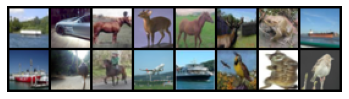

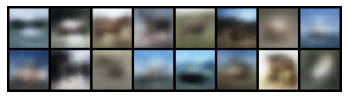

tensor(1904.4069, grad_fn=<DivBackward0>)


In [54]:
def imshow(img):
    npimg = img.numpy()
    
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.axis('off')
    plt.show()

imgs, _ = iter(testSet).next()


def visualize(images, model):
  x_in = images[0: 16].view(-1, 3 * 32 *32)
  x_out, mu, logvar = model(x_in)
  x_out = x_out.data
  loss = criterion(x_out, x_in, mu, logvar)
  imshow(make_grid(x_in.view(-1, 3, 32, 32)))
  imshow(make_grid(x_out.view(-1, 3, 32, 32)))
  return loss

loss = visualize(iter(testSet).next()[0], model)
print(loss)